<a href="https://colab.research.google.com/github/Rohandabas/personality-detection/blob/main/Personality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn imbalanced-learn xgboost nltk transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
      Successfully uninstalled transformers-4.47.1


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [9]:
import os
import zipfile
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Ensure required NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Additional fix: Ensure punkt_tab is explicitly downloaded
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

# Path to the zip file
zip_file_path = '/content/personality detection (1).zip'

# Check if the file exists
if os.path.exists(zip_file_path):
    try:
        # Extract the dataset from the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall('/content/')  # Extract all files to the /content directory
            print("Extraction successful.")

        # Assuming the dataset inside the zip file is named 'mbti_1.csv'
        dataset_path = '/content/mbti_1.csv'
        if os.path.exists(dataset_path):
            # Load the extracted dataset
            data = pd.read_csv(dataset_path)

            # Check the first few rows of the dataset
            print("Dataset loaded successfully:")
            print(data.head())

            # Clean and preprocess the text data
            def clean_text(text):
                text = text.lower()
                text = re.sub(r'http\S+', '', text)  # Remove URLs
                text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
                return text

            # Tokenize, remove stopwords, and lemmatize
            def preprocess_text(text):
                stop_words = set(stopwords.words('english'))
                lemmatizer = WordNetLemmatizer()
                tokens = word_tokenize(text)
                tokens = [word for word in tokens if word not in stop_words]
                tokens = [lemmatizer.lemmatize(word) for word in tokens]
                return " ".join(tokens)

            # Apply the preprocessing to the 'posts' column
            data['cleaned_posts'] = data['posts'].apply(clean_text).apply(preprocess_text)

            # Display the first few rows of the cleaned data
            print("Cleaned Data:")
            print(data[['posts', 'cleaned_posts']].head())

        else:
            print("Error: Dataset 'mbti_1.csv' not found in the extracted files.")

    except zipfile.BadZipFile:
        print("Error: The file is not a valid ZIP file.")
else:
    print(f"Error: The file '{zip_file_path}' does not exist.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Extraction successful.
Dataset loaded successfully:
   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
Cleaned Data:
                                               posts  \
0  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  'I'm finding the lack of me in these posts ver...   
2  'Good one  _____   https://www.youtube.com/wat...   
3  'Dear INTP,   I enjoyed our conversation the o...   
4  'You're fired.|||That's another silly misconce...   

                                       cleaned_posts  
0  intj moment sportscenter top ten play prankswh...  
1  im finding lack post alarmingsex boring positi...  
2  good one _____ course say know thats blessing ...  
3  dear intp enjoyed co

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of MBTI Types'}, xlabel='type'>

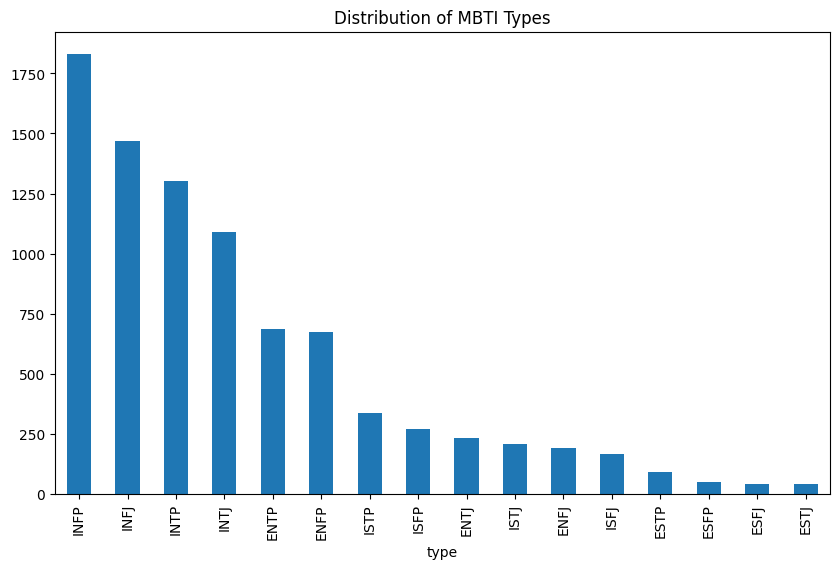

In [11]:
print(data['type'].value_counts())
data['type'].value_counts().plot(kind='bar', figsize=(10, 6), title="Distribution of MBTI Types")


In [12]:
from collections import Counter

all_words = " ".join(data['cleaned_posts']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)
print(most_common_words)


[('like', 68504), ('im', 65312), ('dont', 50951), ('think', 49739), ('people', 45533), ('one', 37270), ('know', 37015), ('really', 34019), ('would', 33717), ('thing', 32969), ('get', 32394), ('time', 31360), ('feel', 24862), ('ive', 23960), ('make', 22893), ('type', 22343), ('much', 22152), ('say', 21947), ('friend', 20917), ('want', 20689)]


<Axes: title={'center': 'Average Post Length by MBTI Type'}, xlabel='type'>

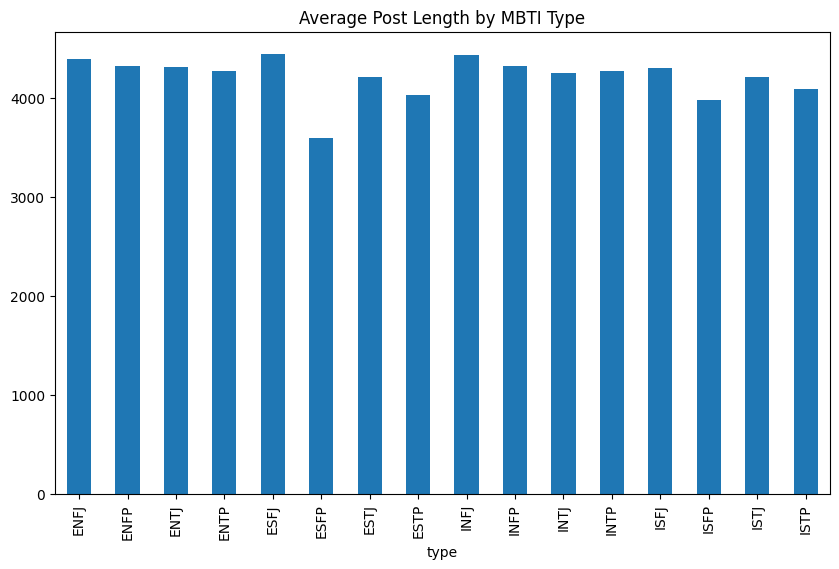

In [13]:
data['post_length'] = data['cleaned_posts'].apply(len)
data.groupby('type')['post_length'].mean().plot(kind='bar', figsize=(10, 6), title="Average Post Length by MBTI Type")


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)  # Limit to top 1000 words
X = vectorizer.fit_transform(data['cleaned_posts']).toarray()


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(data['cleaned_posts']).toarray()


In [17]:
from sklearn.model_selection import train_test_split

X = tfidf_vectorizer.fit_transform(data['cleaned_posts']).toarray()  # Use your chosen feature representation
y = data['type']  # Target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        41
        ENFP       0.64      0.50      0.57       125
        ENTJ       0.57      0.09      0.16        44
        ENTP       0.70      0.46      0.55       135
        ESFJ       0.00      0.00      0.00         7
        ESFP       0.00      0.00      0.00         8
        ESTJ       0.00      0.00      0.00         7
        ESTP       0.00      0.00      0.00        15
        INFJ       0.58      0.70      0.63       288
        INFP       0.52      0.83      0.64       370
        INTJ       0.59      0.65      0.62       193
        INTP       0.64      0.76      0.69       293
        ISFJ       1.00      0.02      0.04        45
        ISFP       0.75      0.06      0.11        53
        ISTJ       0.71      0.11      0.20        44
        ISTP       0.83      0.36      0.50        67

    accuracy                           0.59      1735
   macro avg       0.47   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


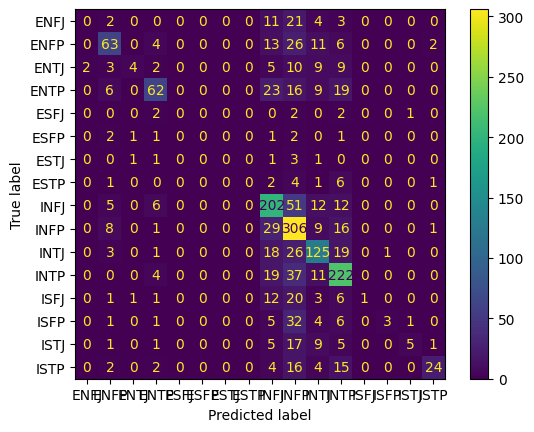

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()


In [20]:
import pickle

# Save the model
with open('mbti_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the model
with open('mbti_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [21]:
new_posts = ["I enjoy deep conversations and exploring new ideas."]
new_posts_cleaned = [preprocess_text(clean_text(post)) for post in new_posts]
new_X = tfidf_vectorizer.transform(new_posts_cleaned).toarray()

predictions = loaded_model.predict(new_X)
print("Predicted MBTI Types:", predictions)


Predicted MBTI Types: ['INFP']


In [22]:
new_posts = [
    "I enjoy deep conversations and exploring new ideas.",
    "I value authenticity and strive to understand others' perspectives."
]


In [23]:
probabilities = loaded_model.predict_proba(new_X)
for mbti_type, prob in zip(loaded_model.classes_, probabilities[0]):
    print(f"{mbti_type}: {prob:.2f}")


ENFJ: 0.00
ENFP: 0.04
ENTJ: 0.00
ENTP: 0.01
ESFJ: 0.00
ESFP: 0.00
ESTJ: 0.00
ESTP: 0.00
INFJ: 0.05
INFP: 0.48
INTJ: 0.04
INTP: 0.11
ISFJ: 0.02
ISFP: 0.03
ISTJ: 0.05
ISTP: 0.17


In [24]:
from sklearn.metrics import accuracy_score

# Assuming 'X_test' is your test features and 'y_test' is your test labels
y_pred = loaded_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 58.62%
